In [16]:
import os
import json
import html
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from datetime import datetime, timedelta, date
import pickle
from sklearn.metrics.pairwise import paired_distances
import time
import random
import matplotlib.pyplot as plt
import copy

# Sorting APS Schedule.

The goal of this notebook is to minimize the amount of overlapping similar talks in the APS schedule. To do this, we swap talks according to the metropolis algorithm. The "energy" we reduce is some product of the cosine similarity between two abstracts and the amount of time they overlap by.

The minimization works the following way: we have three lists. The first contains abstracts for the vectorizer. The second contains the abstracts which we will be sorting, the third contains abstract which overlap in time with the abstracts we are sorting. The first list is a list of dictionaries. This list contains the actual abstracts, time slots, etc... The next two list are just lists of indicies which refer to locations in the first list.

Neighbor information is stored in a single dictionary time_slots. When swaps occur, we only need to change the time slot in the first list, and two numbers in the time_slots dictionary. 

# Formatting the data

We will need to create three lists of abstracts. (1) The first list will be used to create the vector space. This list can be as large as as we'd like to try and improve the similarity metrics. (2) The second list will be used to look for overlaps in time and for making similarity comparisons. This one should include only events which occur in the time period the events we will be swapping take place (e.g. if we only swap events that occur between March 15 - March 19, this list does not need an event which occurs on March 20, BUT the event from march 20 could be in the first list, becuase that might improve the vectorizer). (3) This is the list of events we will try to reorganize. It will be events which are only of a certain duration (12 minutes, 36 minutes etc).

Note each list is a subset of the last list.

In [17]:
"""
This takes a string and removes html tags from it.
"""
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>') #Build re object that looks for html like tags.
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

## List of talks for composing vectorizer

This is the list of abstract we will use to create the vectorizer. We will also use this as a reference when we need information like the time_slot or the abstract. The order of this list will not change, since we will refer to its elements using indicies later on. Each event dictionary needs an id, the index position in the list, the cleaned abstract, and the time interval.

The original JSON file is formatted as shown below.

    {'meeting':
         {'id':308,
          'code':MAR20,
          'title':'APS March Meeting 2020'
          'location':{'city': 'Denver', 'state': 'Colorado', 'country': None},
          'dates':{'starts_on':'2020-03-02','ends_on':'2020-03-06','submission_open_on':'2019-07-01','submission_close_on': '2019-07-02'},
          'description': None ,
          'url': https://www.aps.org/meetings/march/,
          'events':
             [{'type': 'FocusSession',
               'id': 'A10',
               'code': 'A10',
               'title': 'THIS IS THE SESSION TITLE',
               'description': None,
               'tags': 'Focus,GIMS', <---THESE ARE THE TAGS ASSOCAITED WITH THE SESSION
               'sort_number': 200,
               'time_slot': {'starts_at': '2020-03-02T08:00', 'ends_at': '2020-03-02T10:12'},
               'location': {'building': None, 'room': 108},
               'chair': None,
               'abstract_presentations':
                   {'abstract_presentation_id': 369401,
                    'time_slot': {'starts_at': '2020-03-02T08:12', 'ends_at': '2020-03-02T08:24'},
                    'order': 2,
                    'presenter':{'presenter_id':14,'first_name':'D','middle_name':'','last_name':'C','affiliation':'U'},
                    'abstract': 
                        {'abstract_id': 324228,
                         'log_number': 'MAR20-3273737',
                         'title': 'THIS IS THE ACTUAL TALK TITLE',
                         'content': 
                             {format': 'HTML',
                             'abstract': 'THIS IS THE ACTUAL ABSTRACT'}
                         'tags': None,
                         'link': None,
                         'is_invited': False,
                         'title_note': 'Funding was provided by ...',
                         'submitter':{'first_name':'D','last_name':'C','affiliation':'Univ','email':'mail.com','member_id':6},
                         'authors': 
                             [{'author_id': 1496031,
                               'first_name':'D',
                               'middle_name': '',
                               'last_name': 'C',
                               'affiliation': 'Univ',
                               'email': 'd.collomb@bath.ac.uk',
                               'image_url': None}, ...],
                         'teams': None}}}...]

We'd like to convert the 2021 abstract json file to the following format:

    {'_id':"2019_MARCH_K49_9",
     'index': 54
     'cleanAbstract': 'Current ionic liquid .......',
     'time_slot':[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]}

In [147]:
path = "MAR21_Bulletin_2021-01-13T15-19-18.json" #if you move this json file or the notebook itself the path will be invalid 😃

#Read in the raw json file
with open(path,"r",encoding='utf_8') as file:
    abstractsRawJSON = file.read()

abstractsRaw = json.loads(abstractsRawJSON)

In [19]:
#Here we iterate through the json file and grab the stuff we want. The json files are imported as dictionaries.
minLength = 0
total = 0
index = 0
abstracts = [] #this one will have its elements manipulated
for event in abstractsRaw['meeting']['events']:
    for presentation in event['abstract_presentations']:
        total += 1
        _id = "2021_MARCH_" + event['id'] +"_"+ str(presentation['order'])
        title = presentation['abstract']['title']
        abstract = presentation['abstract']['content']['abstract']
        
        time_slot = [datetime.strptime(presentation['time_slot']['starts_at'], '%Y-%m-%dT%H:%M'),datetime.strptime(presentation['time_slot']['ends_at'], '%Y-%m-%dT%H:%M')]
        startTime = time_slot[0]
        endTime = time_slot[1]
        
        if len(abstract) >= minLength:
            eventDict = {}
            eventDict['_id'] = _id
            eventDict['index'] = index
            eventDict['cleanAbstract'] = html.unescape(cleanhtml(title +" "+ abstract)).strip() #Here we clean any html tags from the abstract and title. This is the text we'll use in our vectorizer.
            eventDict['time_slot'] = time_slot
            
            abstracts.append(eventDict)
            index += 1
abstractsStatic = copy.deepcopy(abstracts) #This list will remain unchanged
f"Using {len(abstracts)} / {total} abstracts"

'Using 10809 / 10809 abstracts'

In [20]:
abstracts_df = pd.DataFrame(abstracts) #Convert list of dictionaries to dataframe
abstracts_df.head()

,_id,index,cleanAbstract,time_slot
0,2021_MARCH_2A_1,0,DPOLY Short Course: Macromolecular Engineering...,"[2021-03-13 08:30:00, 2021-03-13 15:15:00]"
1,2021_MARCH_3A_1,1,T1. Density Functional Theory Density Function...,"[2021-03-14 08:30:00, 2021-03-14 12:30:00]"
2,2021_MARCH_3B_1,2,T2. Active Learning and AI for Computational a...,"[2021-03-14 08:30:00, 2021-03-14 12:30:00]"
3,2021_MARCH_3C_1,3,T3. Noisy Quantum Devices The last few years h...,"[2021-03-14 08:30:00, 2021-03-14 12:30:00]"
4,2021_MARCH_3D_1,4,T4. Fermi-Hubbard Systems TBD,"[2021-03-14 08:30:00, 2021-03-14 12:30:00]"


## List of talks for identifying temporal overlaps and computing similarity scores

This is a list of indicies. This list contains all the events which overlap in time with events in the subsequent list. We will use this list of abstract comparison and computing temporal overlaps.

The list is of the form: [4605, 4606, 4607, 4608,...]

In [21]:
#Here we iterate through the list of event dictionaries and grab the indicies of the talks which occur between certain dates.
startDate = datetime(2021,3,17,hour=8) #This is the start time of the first 12 minute talk
endDate = datetime(2021,3,17,hour=11)

#datetime(2021,3,19,hour=13,minute=33) #This is the end time of the last 12 minute talk

total = 0
abstractsForComparison = []
for i in range(len(abstracts)):
    total += 1
    event = abstracts[i]
    time_slot = event['time_slot']
    startTime = time_slot[0]
    endTime = time_slot[1]

    if endTime > startDate and startTime < endDate:
        abstractsForComparison.append(i)
        
f"Using {len(abstractsForComparison)} / {total} abstracts"

'Using 736 / 10809 abstracts'

## List of talks for sorting

This is a list of indicies. This is the actual list of talks that will be sorted. For now, we will restrict the length to just the 12 minutes talks so we don't have to worry about different sized time slots. 

The list is of the form: [4605, 4606, 4607, 4608,...]

In [22]:
#Here we iterate through the list of event dictionaries and grab the indicies of the talks which occur between certain dates and are a certain length.
minLength = 0
#startDate = datetime(2021,3,15,hour=8) #This is the start time of the first 12 minute talk
#endDate = datetime(2021,3,19,hour=13,minute=33) #This is the end time of the last 12 minute talk
allowedDurations = [timedelta(hours=0,minutes=12)]

total = 0
abstractsForSorting = []
for i in range(len(abstracts)):
    total += 1
    event = abstracts[i]
    time_slot = event['time_slot']
    startTime = time_slot[0]
    endTime = time_slot[1]
    duration = endTime - startTime

    if endTime > startDate and startTime < endDate and duration in allowedDurations:
        abstractsForSorting.append(i)

f"Using {len(abstractsForSorting)} / {total} abstracts"

'Using 649 / 10809 abstracts'

In [23]:
N = len(abstractsForSorting) #The number of abstracts we are sorting

## Relating similar talks

Here we plug the abstracts into a tfidf vecotrizer to create a weighted document term matrix (a big matrix of word frequencies weighted by the importance of each word). Then we relate find similar talks by taking the cosine of each vector in the document term matrix. We do this using a convient nearest nieghbor method. 

In [24]:
vectorizerOps = {'max_features': None, #consider only top N words for vocabulary, None does not limit
                 'min_df': .005, #minmum percent of docs needed to have a word for it to be considered (ignoring very rare words)
                 'max_df': .90, #maximum percent of docs needed to have a word for it to be ignored (ignoring very common words)
                 'ngram_range':(1,4), #length of words combinations to look for 
                 'stop_words':'english'} #special list of words to be ignored (words like 'the' or 'is')

In [25]:
#Converting data into a word frequency vector space
v = TfidfVectorizer(**vectorizerOps)

In [26]:
#This is just a mtrix of word freuncies for every document.
embedding = v.fit_transform(abstracts_df['cleanAbstract']) #Docs are rows, vocab is columns. embedding[i] gets ith row
print(f"Vector space is composed of {len(v.get_feature_names())} features.")

Vector space is composed of 3217 features.


# Finding time interval overlaps

We need to be able to tell if two talks overlap. The function below accomplishes this.

In [27]:
"""
Returns True if the time intervals interval1 and interval 2 overlap. Events which start or end at the same time are NOT 
considered to overlap

inputs:
interval1 is a two element list. Both elements are datetime objects. The first element is assumed to be before the second.
interval2 is a two element list. Both elements are datetime objects. The first element is assumed to be before the second.

output
boolean True is intervals overlap, false otherwise.
"""
def overlapQ(interval1,interval2, buffer = 0):
    s1 = interval1[0]
    e1 = interval1[1]
    s2 = interval2[0]
    e2 = interval2[1]
    if s1 >= e2: #1 starts after 2 ends
        return False
    else: #1 starts before 2 ends
        if s1 >= s2: #1 starts after 2 starts or they start at the same time
            return True
        else: #1 starts before 2
            if e1 <= s2: #1 ends before 2 starts or 1 ends when 2 starts
                return False
            else: #1 ends after 2 starts
                return True

In [28]:
time1 = [datetime.strptime('2020-03-02T08:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T09:00', '%Y-%m-%dT%H:%M')]
time2 = [datetime.strptime('2020-03-02T09:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T10:00', '%Y-%m-%dT%H:%M')]
overlapQ(time1,time2)

False

In [29]:
time1 = [datetime.strptime('2020-03-02T08:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T09:30', '%Y-%m-%dT%H:%M')]
time2 = [datetime.strptime('2020-03-02T09:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T10:00', '%Y-%m-%dT%H:%M')]
overlapQ(time1,time2)

True

In [30]:
"""
Returns amount of time interval1 and interval 2 overlap by. Events which start or end at the same time are NOT 
considered to overlap.

inputs:
interval1 is a two element list. Both elements are datetime objects. The first element is assumed to be before the second.
interval2 is a two element list. Both elements are datetime objects. The first element is assumed to be before the second.

output
Returns a floating point number greater than or equal to zero. 
"""
def overlap(interval1,interval2, buffer = 0):
    if overlapQ(interval1,interval2):
        s1 = interval1[0]
        e1 = interval1[1]
        s2 = interval2[0]
        e2 = interval2[1]
        
        latestStart = max(s1,s2)
        earliestEnd = min(e1,e2)
        
        return earliestEnd-latestStart
    else:
        return timedelta() #zero seconds

In [31]:
time1 = [datetime.strptime('2020-03-02T08:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T09:00', '%Y-%m-%dT%H:%M')]
time2 = [datetime.strptime('2020-03-02T09:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T10:00', '%Y-%m-%dT%H:%M')]
overlap(time1,time2).total_seconds()/3600 #amount of overlap in hours

0.0

In [32]:
time1 = [datetime.strptime('2020-03-02T08:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T09:30', '%Y-%m-%dT%H:%M')]
time2 = [datetime.strptime('2020-03-02T09:00', '%Y-%m-%dT%H:%M'),datetime.strptime('2020-03-02T10:00', '%Y-%m-%dT%H:%M')]
overlap(time1,time2).total_seconds()/3600 #amount of overlap in hours

0.5

## Creating a seperate list of time slots and the talks which overlap with each.

We would like to make a dictionary of the form:

    {'2021-03-17 08:36:00--2021-03-17 08:48:00': [4606,4611,...],
     '2021-03-17 08:24:00--2021-03-17 08:36:00': [4605,4609,...]...}

where the keys are time intervals and the lists are all the talks which occur at those times. The keys will be composed of all the time intervals which occur for talks included in abstractsForSorting. The list of indicies will include all talks in abstractsForComparison.

In [33]:
"""
Takes a string time interval of the form '2021-03-17 08:36:00--2021-03-17 08:48:00' and converts it into a list of two datetime objects of the form [datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]
"""
def convertIntervalString(intervalString):
    return [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in intervalString.split("--")]

"""
Takes a list of two datetime objects of the form [datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)] and converts it into a string of the form '2021-03-17 08:36:00--2021-03-17 08:48:00'
"""
def createIntervalString(interval):
    return f"{interval[0]}--{interval[1]}"

In [34]:
#Create a dictionary whihc has all the avaible timeslots for talks we plan to sort
time_slots = {}
for i in abstractsForSorting:
    interval = abstracts[i]['time_slot']
    intervalString = createIntervalString(interval)
    if intervalString not in time_slots:
        time_slots[intervalString] = []

#Fill the dictionary with all the talks which occur in those timeslots. This is essentially a neighbor map.
for i in abstractsForComparison:
    afcInterval = abstracts[i]['time_slot'] #This is an interval from abstractsForComparison
    for time_slot in time_slots:
        afsInterval = convertIntervalString(time_slot) #This is an interval from abstractsForSorting
        if overlapQ(afsInterval,afcInterval): 
            time_slots[time_slot].append(i)
time_slotsStatic = copy.deepcopy(time_slots) #this copy will remain unchanged

In [151]:
createIntervalString(abstracts[4663]['time_slot'])

'2021-03-17 08:36:00--2021-03-17 08:48:00'

In [152]:
convertIntervalString(createIntervalString(abstracts[4663]['time_slot']))

[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]

In [35]:
print(time_slots[createIntervalString(abstracts[4663]['time_slot'])])

[4606, 4611, 4622, 4635, 4650, 4663, 4676, 4691, 4699, 4706, 4719, 4732, 4744, 4757, 4769, 4776, 4788, 4799, 4805, 4814, 4827, 4837, 4851, 4864, 4877, 4886, 4894, 4907, 4920, 4934, 4948, 4961, 4976, 4989, 5001, 5008, 5020, 5030, 5043, 5054, 5069, 5084, 5099, 5114, 5129, 5143, 5157, 5172, 5182, 5187, 5193, 5206, 5219, 5228, 5240, 5253, 5264, 5274, 5281, 5294, 5306, 5315, 5320, 5332]


# Cost Function

We need a function which will compute the cost of two overlapping events. The cost function should be proportional to the amount of time the events overlap and their similarity.

In [36]:
"""
Takes two event dictionaries and computes the cost of them as is.
Cost is computed as the amount of time two talks overlap by in 
hours multiplied by the cosine similarity between thier abstracts.

Inputs:
event1: This is an event dictionary formatted like:
        {'_id':"2019_MARCH_K49_9",
         'index': 54
         'cleanAbstract': 'Current ionic liquid .......',
         'time_slot':[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]}
         
event2: This is another event formatted the same way.

returns a floating point number
"""
def singleCost(event1, event2):
    interval1 = event1['time_slot']
    interval2 = event2['time_slot']
    duration = overlap(interval1,interval2).total_seconds()/3600 #amount of overlap in hours
    
    index1 = event1['index']
    index2 = event2['index']
    
    similarity = 1-paired_distances(embedding[index1],embedding[index2], metric='cosine')[0] #how similar the talks are

    if similarity<0:
        similarity = 0.0
    
    return duration*similarity

In [37]:
singleCost(abstracts[4663],abstracts[4606])

0.0010289408023736568

In [153]:
"""
Compute the cost of the current position of an event. This is the sum of singleCost for all the talks
which overlap with event according to the neighbor list time_slots.

Inputs:
event: This is an event dictionary formatted like:
        {'_id':"2019_MARCH_K49_9",
         'index': 54
         'cleanAbstract': 'Current ionic liquid .......',
         'time_slot':[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]}

time_slotsDic: Dictionary of time slots and the indicies of talks associated with them.
            the defualt option time_slots changes when swaps are made during the minimization.
            there is also time_slotsStatic which is left with the original set of indicies.
            the dictionary is of the form
            
            {'2021-03-17 08:36:00--2021-03-17 08:48:00': [4606,4611,...],
             '2021-03-17 08:24:00--2021-03-17 08:36:00': [4605,4609,...]...}
             
abstractsList: list of event dictionaries of the form [event1,event2,...] where each event is formatted as
               described above. The defualt options abstracts changes when swaps are made during the minimization.
               there is also abstractsStatic which is left unchanged.
               
returns a floating point number
"""
def cost(event,time_slotsDic=time_slots,abstractsList=abstracts):
    i = event['index']
    interval = event['time_slot']
    intervalString = createIntervalString(interval)
    neighbors = time_slotsDic[intervalString]
    costs = [singleCost(event,abstractsList[j]) if i!=j else 0 for j in neighbors]
    return sum(costs)

In [39]:
cost(abstracts[4663])

0.18290786901725026

In [40]:
cost(abstracts[4663],time_slotsDic=time_slotsStatic, abstractsList=abstractsStatic)

0.18290786901725026

In [41]:
"""
return the total cost of the current ordering of talks. 
Uses time_slots and abstracts objects which change 
during the minimization.

returns a floating point number.
"""
def totalCost():
    return 0.5*sum([cost(abstracts[i]) for i in abstractsForSorting])

In [42]:
#This takes a very long time to run
#totalCost()

124.30242640065906

In [43]:
"""
Computes the cost of two talks if one were to occur at a different time. 
Intended use case is to pass some event1, the interval of some other event2, 
and then some third event3 which occurs at the same time as event2.

Inputs:
event1: This is an event dictionary formatted like:
        {'_id':"2019_MARCH_K49_9",
         'index': 54
         'cleanAbstract': 'Current ionic liquid .......',
         'time_slot':[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]}

interval1: This is a list of datetime objects of the form [datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]
         
event2: This is another event formatted the same way.

returns a floating point number.
"""
def singleSwapCost(event1, interval1, event2):
    interval2 = event2['time_slot']
    duration = overlap(interval1,interval2).total_seconds()/3600 #amount of overlap in hours
    
    index1 = event1['index']
    index2 = event2['index']
    
    similarity = 1-paired_distances(embedding[index1],embedding[index2], metric='cosine')[0] #how similar the talks are

    if similarity<0:
        similarity = 0.0
    
    return duration*similarity

In [44]:
singleSwapCost(abstracts[4000],abstracts[4663]['time_slot'],abstracts[4606])

0.028453256340519564

In [45]:
"""
Computes the total cost of swapping two events.

Inputs:
event1: This is an event dictionary formatted like:
        {'_id':"2019_MARCH_K49_9",
         'index': 54
         'cleanAbstract': 'Current ionic liquid .......',
         'time_slot':[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]}

event2: This is another event formatted the same way.

returns a floating point number.
"""
def swapCost(event1,event2):
    index1 = event1['index']
    index2 = event2['index']
    
    interval1 = event1['time_slot']
    interval2 = event2['time_slot']
    
    neighbors1 = time_slots[createIntervalString(interval1)]
    neighbors2 = time_slots[createIntervalString(interval2)]
    
    cost1 = sum([singleSwapCost(event1,interval2,abstracts[j]) if index1!=j and index2!=j else 0 for j in neighbors2])
    cost2 = sum([singleSwapCost(event2,interval1,abstracts[j]) if index1!=j and index2!=j else 0 for j in neighbors1])
    
    return (cost1,cost2)

In [50]:
swapCost(abstracts[4663],abstracts[4664])

(0.1799480576898917, 0.3365878403870761)

# Swap Function

This is a function which will (efficiently?) swap event informoartion in the bastract list of dictionaries. The information we will need to change would be the times, the cost, and the nieghbors. We will also need to go to each of the nieghbors and update thier neighbor list.

In [47]:
"""
Swaps two events. Swaps the events indicies in the time_slots dictionary.

Inputs:
event1: This is an event dictionary formatted like:
        {'_id':"2019_MARCH_K49_9",
         'index': 54
         'cleanAbstract': 'Current ionic liquid .......',
         'time_slot':[datetime.datetime(2021, 3, 17, 8, 36), datetime.datetime(2021, 3, 17, 8, 48)]}

event2: This is another event formatted the same way.
"""
def swap(event1, event2):
    index1 = event1['index']
    index2 = event2['index']
    
    time_slot1 = event1['time_slot']
    time_slot2 = event2['time_slot']
    
    intervalString = createIntervalString(time_slot1)
    for i,neighbor in enumerate(time_slots[intervalString]):
        if neighbor == index1:
            break
    time_slots[intervalString][i] = index2
    
    intervalString = createIntervalString(time_slot2)
    for i,neighbor in enumerate(time_slots[intervalString]):
        if neighbor == index2:
            break
    time_slots[intervalString][i] = index1
    
    abstracts[index1]['time_slot'] = time_slot2
    abstracts[index2]['time_slot'] = time_slot1

In [48]:
print(abstracts[4663],"\n")
print(time_slots[createIntervalString(abstracts[4663]['time_slot'])])

{'_id': '2021_MARCH_L06_3', 'index': 4663, 'cleanAbstract': 'Modeling Elastocapillary Adhesion of Compliant Gel Microspheres A common feature in adhesion and wetting systems is a meniscus. Yet, most adhesive models do not account for the role it plays. Historically, contact models have been treated separately from models of capillarity due to the complexity of elasticity at large deformations. Here, we consider a system at the intersection of these two extremes. We explore the adhesion of a gel sphere to a rigid substrate. As the gel is deformed, a liquid fraction is expelled to form a meniscus with the surface. This meniscus adds additional contact area between the gel and substrate, changing the energetic contributions due to adhesion and surface tension. In comparison with experiment, we find that established contact models underestimate the contact area, especially at low Youngs moduli. To better understand this system, we have built on previous contact and capillary models to deve

In [ ]:
print(abstracts[4000],"\n")
print(time_slots[createIntervalString(abstracts[4000]['time_slot'])])

In [ ]:
#swap(abstracts[4000], abstracts[4663]) #If you run this, be sure to swap them back!

In [ ]:
print(abstracts[4663],"\n")
print(sorted(time_slots[createIntervalString(abstracts[4663]['time_slot'])]))

In [ ]:
print(abstracts[4000],"\n")
print(sorted(time_slots[createIntervalString(abstracts[4000]['time_slot'])]))

# Session Information

This creates a list of all the events in each session which takes place during the time range of consideration. The dictionary is of the form:

    {'L02': [4610, 4611,...],
     'L03': [4621, 4622,...],
     'L04': [4633, 4687,...],...}

In [48]:
sessions = {}
for i in abstractsForSorting:
    abstract = abstracts[i]
    _id = abstract['_id']
    index = abstract['index']
    session = _id.split("_")[2]
    if session not in sessions:
        sessions[session] = [index]
    else:
        sessions[session].append(index)

In [49]:
print(sessions['L06'])

[4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673]


# Reorganizng schedule

In [51]:
random.seed(1337) #uses current time as seed

In [52]:
iterations = N*10 #Number of iterations
noise = 100 #0 means all cost increasing moves are accepts, higher means less moves accepted.

In [53]:
initialCost = totalCost() #Get intial total cost
finalCost = initialCost

In [54]:
info = []

In [55]:
for i in range(iterations):
    #Random swapping of abstracts so long as they don't occur at the same time.
#     indexA = random.choice(abstractsForSorting)
#     indexB = random.choice(abstractsForSorting)
    
#     eventA = abstracts[indexA]
#     eventB = abstracts[indexB]
    
#     while eventA['time_slot'][0] == eventB['time_slot'][0] and eventA['time_slot'][1] == eventB['time_slot'][1]:
#         indexA = random.choice(abstractsForSorting)
#         indexB = random.choice(abstractsForSorting)
        
#         eventA = abstracts[indexA]
#         eventB = abstracts[indexB]

    #Random swapping of abstracts so long as they are in the same session.
    indexA = random.choice(abstractsForSorting) #Get an index
    eventA = abstracts[indexA] #Get event associated with index
    sessionA = eventA['_id'].split("_")[2] #Get session code of eventA
    
    indexB = random.choice(sessions[sessionA]) #Get index from the same session as eventA
    while indexA == indexB: #Make sure eventA and eventB are not the same
        indexB = random.choice(sessions[sessionA])
    eventB = abstracts[indexB]
    
    #Get cose of eventA & eventB
    costA0 = cost(eventA)
    costB0 = cost(eventB)
    cost0 = costA0 + costB0
    
    #Get cost of swapping eventA & eventB
    (costA1,costB1) = swapCost(eventA,eventB)
    cost1 = costA1 + costB1
    
    #Swap according to metropolis alogirthm
    dCost = cost1 - cost0
    swapped = False
    if dCost < 0: #If swap reduces cost, accept
        swap(eventA, eventB)
        swapped = True
        finalCost += dCost #Update cost
    elif random.random() <= np.exp(-dCost*noise): #If swap increases energy, swap according to Boltzmann distro
        swap(eventA, eventB)
        swapped = True
        finalCost += dCost
    
#     if swapped:
#         print(i,"accepted!")
#     else:
#         print(i," rejected!")
    
    info.append([(indexA, indexB), swapped, dCost,finalCost])

# Analysis

### Cost as a function of sweep

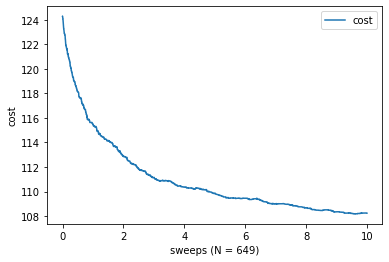

In [56]:
energy = [info[i][3] for i in range(len(info))]
count = [i/N for i in range(len(info))]
plt.plot(count,energy,label="cost")
plt.legend(loc="upper right")
plt.xlabel(f"sweeps (N = {N})")
plt.ylabel("cost")
plt.show()

#plt.savefig("costVsSweeps_withinSession.png",dpi=200)

### Looking at all the changes for a specific session

In [57]:
for index in sessions['L06']:
    oldEvent = abstractsStatic[index]
    oldTime = oldEvent["time_slot"]
    oldScore = cost(oldEvent, time_slotsDic=time_slotsStatic, abstractsList=abstractsStatic)
    
    newEvent = abstracts[index]
    newTime = newEvent["time_slot"]
    newScore = cost(newEvent)
    
    abstract = abstracts[index]["cleanAbstract"]
    print(f"Old Score: {oldScore:.4f}     New Score: {newScore:.4f}")
    print(f"Old Time: {oldTime[0].hour}:{oldTime[0].minute:02d}-{oldTime[1].hour}:{oldTime[1].minute:02d}   New Time: {newTime[0].hour}:{newTime[0].minute:02d}-{newTime[1].hour}:{newTime[1].minute:02d}")
    print(abstract,"\n")

Old Score: 0.2855     New Score: 0.2389
Old Time: 8:36-8:48   New Time: 8:48-9:00
Quantifying failure in geometrically confined adhesives by pressure-induced cavitation Many practical adhesives fail by the growth of interfacial cavities. Conventional contact adhesion measurements relate cavity growth to adhesive performance by recording force, displacement and contact images. Still, the influence of internal pressure within the cavities is an open question. Thus, in-situ cavity pressure measurements will enrich quantitative understanding of adhesive failure mechanisms. Here, we report a contact adhesion testing instrument that applies positive pressure at the contact interface to induce cavitation. We combine experiments with finite element analysis to develop models relating the pressure response in acrylic adhesives and silicone elastomers to their quanitative bulk and interfacial properties, including the elastic modulus and the critical strain energy release rate. Moreover, our exp

### Identifying swaps that created the largest cost changes

In [136]:
NSwaps = 3
largestChanges = []
for j in range(NSwaps):
    change = 0
    minIndex = 0
    for i in range(len(info)):
        values = info[i]
        if change > values[2] and i not in largestChanges:
            change = values[2]
            minIndex = i
    largestChanges.append(minIndex)

In [137]:
for i in largestChanges:
    values = info[i]
    timeA = abstracts[values[0][0]]["time_slot"]
    timeB = abstracts[values[0][1]]["time_slot"]
    
    abstractA = abstracts[values[0][0]]["cleanAbstract"]
    abstractB = abstracts[values[0][1]]["cleanAbstract"]
    
    print(f"Swap Score: {values[2]:.4f}")
    print(f"New Time: {timeA[0].hour}:{timeA[0].minute:02d}-{timeA[1].hour}:{timeA[1].minute:02d}")
    print(abstractA,"\n")
    print(f"New Time: {timeB[0].hour}:{timeB[0].minute:02d}-{timeB[1].hour}:{timeB[1].minute:02d}")
    print(abstractB,"\n","\n")

Swap Score: -0.1966
New Time: 10:24-10:36
Quantum Transport on MnBi2Te4 Thin Films Grown on Sapphire MnBi2Te4 has recently emerged as an intrinsic magnetic topological insulator that possesses both magnetic and topological properties. Perhaps most interestingly it possesses a unique set of thickness dependent properties in the ultra-thin limit.1 Transitioning from 2D ferromagnetic insulator as a single layer to an axion insulator with even layer thickness, to wide bandgap quantum anomalous Hall insulator with odd layer number.2,3 Yet, the majority of experiments have been on small exfoliated crystals which have confirmed the axion and Quantum anomalous Hall insulator phases, whilst large area films grown epitaxially possess large intrinsic n-type doping preventing access to these quantum phases.1 Here, we report the growth of ultra-thin MnBi2Te4 on sapphire by molecular beam epitaxy. By carefully controlling the growth parameters we are able to achieve low-doped films of well-defined t

[(10.166666666666666, 0.2), (8.133333333333333, 0.2), (9.15, 0.2), (8.133333333333333, 0.2), (10.166666666666666, 0.2), (9.15, 0.2), (10.166666666666666, 0.2), (8.133333333333333, 0.2), (8.133333333333333, 0.2)]
[(10.166666666666666, 0.2), (10.166666666666666, 0.2), (8.133333333333333, 0.2), (9.15, 0.2), (9.15, 0.2), (9.15, 0.2), (9.15, 0.2), (10.166666666666666, 0.2), (8.133333333333333, 0.2), (10.166666666666666, 0.2), (10.166666666666666, 0.2), (10.166666666666666, 0.2)]
[(8.133333333333333, 0.2), (8.133333333333333, 0.2), (10.166666666666666, 0.2), (9.15, 0.2), (9.15, 0.2), (9.15, 0.2), (9.15, 0.2), (10.166666666666666, 0.2), (10.166666666666666, 0.2), (10.166666666666666, 0.2), (9.15, 0.2), (10.166666666666666, 0.2)]
[(8.133333333333333, 0.2), (8.133333333333333, 0.2), (8.133333333333333, 0.2), (10.166666666666666, 0.2), (8.133333333333333, 0.2), (10.166666666666666, 0.2), (10.166666666666666, 0.2), (9.15, 0.2), (9.15, 0.2), (9.15, 0.2), (9.15, 0.2), (10.166666666666666, 0.2), (10

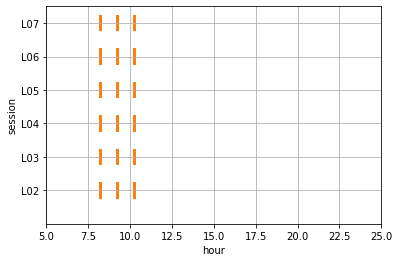

In [134]:
fig, gnt = plt.subplots() # Declaring a figure "gnt"
gnt.set_ylim(0, 65)
gnt.set_xlim(5, 25)
gnt.set_xlabel('hour')
gnt.set_ylabel('session')

gnt.set_yticks([i for i in range(10,7*10,10)])
gnt.set_yticklabels(list(time_slots.keys())[:6])
gnt.grid(True)

width = 5
wiggle = 0

count = 0
for i,session in enumerate(time_slots):
    count += 1
    indices = time_slots[session]
    timeList = []
    for index in indices:
        time_slot = abstracts[index]['time_slot']
        start = time_slot[0]
        end = time_slot[1]
        duration = (end - start).total_seconds()/3600 #length of event in hours
        
        startHours = start.hour + start.hour/60 + wiggle
        endHours = startHours + duration - wiggle
        timeList.append((startHours,duration))
    print(timeList)
    gnt.broken_barh(timeList, ((i+1)*10-2.5, width), facecolors =('tab:orange'))
    
    if count > 5:
        break

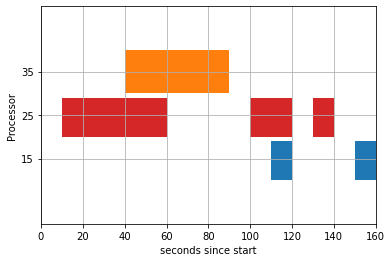

In [99]:
# Declaring a figure "gnt"
fig, gnt = plt.subplots()
 
# Setting Y-axis limits
gnt.set_ylim(0, 50)
 
# Setting X-axis limits
gnt.set_xlim(0, 160)
 
# Setting labels for x-axis and y-axis
gnt.set_xlabel('seconds since start')
gnt.set_ylabel('Processor')
 
# Setting ticks on y-axis
gnt.set_yticks([15, 25, 35])
# Labelling tickes of y-axis
gnt.set_yticklabels(['15', '25', '35'])
 
# Setting graph attribute
gnt.grid(True)
 
# Declaring a bar in schedule
gnt.broken_barh([(40, 50)], (30, 10), facecolors =('tab:orange'))
 
# Declaring multiple bars in at same level and same width
gnt.broken_barh([(110, 10), (150, 10)], (10, 9),
                         facecolors ='tab:blue')
 
gnt.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9),
                                  facecolors =('tab:red'))
 
#plt.savefig("gantt1.png")

# Exporting

### Exporting an updated json schedule

In [142]:
abstractsRawStatic = copy.deepcopy(abstractsRaw)
#abstractsRaw = copy.deepcopy(abstractsRawStatic)

In [148]:
#Here we iterate through the raw json and update the times for each presentation we sorted.
#Then we reorder them according to thier updated times.
#Finally, we update the talk order so it is correct.
finalSwaps = {}
for event in abstractsRaw['meeting']['events']:
    #update the times for each abstract in a session
    sessionCode = event['id']
    finalSwaps[sessionCode] = []
    for presentation in event['abstract_presentations']:
        _id = "2021_MARCH_" + sessionCode +"_"+ str(presentation['order'])
        for index in abstractsForSorting: #This is not efficient
            _idSorted = abstracts[index]['_id']
            
            if _id == _idSorted:
                newTime = abstracts[index]['time_slot']
                newStart = newTime[0].strftime('%Y-%m-%dT%H:%M')
                newEnd = newTime[1].strftime('%Y-%m-%dT%H:%M')
                
                presentation['time_slot']['starts_at'] = newStart
                presentation['time_slot']['ends_at'] = newEnd
    
    #Sort the abstracts within a session by start time
    newPresentation = [event['abstract_presentations'][0]]
    for presA in event['abstract_presentations'][1:]:
#         #This block prints out the newPresentation list as it grows for a specific session. For debugging
#         if event['id'] == "L06":
#             for presentation in newPresentation:
#                 title = presentation['abstract']['title']
#                 order = presentation['order']
#                 time_slot = [datetime.strptime(presentation['time_slot']['starts_at'], '%Y-%m-%dT%H:%M'),datetime.strptime(presentation['time_slot']['ends_at'], '%Y-%m-%dT%H:%M')]
#                 print(f"{order} {time_slot[0].hour}:{time_slot[0].minute:02d}-{time_slot[1].hour}:{time_slot[1].minute:02d}")
#                 print(title,"\n")
#             print("______________________________")         
        inserted = False
        startA = datetime.strptime(presA['time_slot']['starts_at'], '%Y-%m-%dT%H:%M')
        for i,presB in enumerate(newPresentation):
            startB = datetime.strptime(presB['time_slot']['starts_at'], '%Y-%m-%dT%H:%M')
            if startB > startA:
                newPresentation.insert(i,presA)
                inserted = True
                break
        if not inserted:
            newPresentation.append(presA)
    
    #Update the order numbers
    for i,pres in enumerate(newPresentation):
        title = pres['abstract']['title']
        abstract_presentation_id = pres["abstract_presentation_id"]
        oldOrder = pres['order']
        newOrder = i+1
        pres['order'] = newOrder 
        finalSwaps[sessionCode].append({"abstract_presentation_id":abstract_presentation_id,"title":title,"oldOrder":oldOrder,"newOrder":newOrder})
        
    
    #Overwrite the existing information
    event['abstract_presentations'] = newPresentation

In [149]:
#This will export the updated schedule JSON
fileExtension = "_sorted" #file will be exported as whatever the input file is called with this extension appened to the end
pathBasename = path[:path.rfind(".")]
saveName = pathBasename + fileExtension +".json"
with open(saveName, "w") as f:
    json.dump(abstractsRaw,f,indent=4)

#This will export the swaps information
fileExtension = "_swaps"    
saveName = pathBasename + fileExtension +".json"
with open(saveName, "w") as f:
    json.dump(finalSwaps,f,indent=4)